<a href="https://colab.research.google.com/github/MS-H2020/Open/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [鋳造製品の欠陥検出](https://signate.jp/competitions/406)

## Google Colabでの設定

In [36]:
from google.colab import drive
drive.mount('/content/drive')
!cp "/content/drive/MyDrive/Colab Notebooks/01_input.zip" .

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/')

In [38]:
TEMP_DIR = "./temp"
INPUT_DIR:str = TEMP_DIR + "/01_input"
TRAIN_DIR:str = INPUT_DIR + "/train_data"
TEST_DIR:str = INPUT_DIR + "/test_data"
ANALYSIS_DIR:str = "/content/drive/MyDrive/Colab Notebooks/03_code-analysis"
MODEL_DIR:str = "/content/drive/MyDrive/Colab Notebooks//04_model"
SUBMISSION_DIR:str = '/content/drive/MyDrive/Colab Notebooks/05_submission'
CHECKPOINT_PATH:str = MODEL_DIR

In [39]:
import shutil
import os

if os.path.isdir(TEMP_DIR):
  shutil.rmtree(TEMP_DIR)

import glob
import zipfile
shutil.unpack_archive('01_input.zip', TEMP_DIR)

## メインコード

In [40]:
import os
import time

"""
from util import Logger, Util
logger = Logger()
"""

from typing import Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow
from tensorflow import keras
from tensorflow.keras import models, datasets, layers, applications, optimizers
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator

tensorflow.compat.v1.logging.set_verbosity(tensorflow.compat.v1.logging.ERROR)

In [41]:
############# Initial Setting #####################################
"""
INPUT_DIR:str = "../01_input"
TRAIN_DIR:str = INPUT_DIR + "/train"
TEST_DIR:str = INPUT_DIR + "/test"
ANALYSIS_DIR:str = "../03_code-analysis"
MODEL_DIR:str = "../04_model"
SUBMISSION_DIR:str = '../05_submission'
CHECKPOINT_PATH:str = MODEL_DIR
"""

IMG_WIDTH:int = 300
IMG_HEIGHT:int = 300
IMG_DEPTH:int = 3
BATCH_SIZE:int = 16 #Default:32

OneHold_or_Kfold : bool = True

fold_num:int = 3 # Default:9
architecture:str = "mobile-net"
#architecture:str = "DenseNet"
#architecture:str = "VGG"
#architecture:str = "efficient-net"

#model_ver:int = 1
epochs:int = 50 # Defalut:50
lr:float = 0.001 # Default:0.001

#################################################################

In [42]:
# 不要なコード
df = pd.read_csv(INPUT_DIR+"/train.csv")
df
############

,id,target
0,cast_def_0_335.jpeg,0
1,cast_def_0_323.jpeg,0
2,cast_def_0_61.jpeg,0
3,cast_def_0_163.jpeg,0
4,cast_def_0_175.jpeg,0
...,...,...
245,cast_ok_0_346.jpeg,1
246,cast_ok_0_307.jpeg,1
247,cast_ok_0_242.jpeg,1
248,cast_ok_0_184.jpeg,1


In [43]:
#logger.info('start def make_df()')

df = pd.read_csv(INPUT_DIR+"/train.csv")
df['target'] = df['target'].astype(str)

#logger.info('end def make_df()')

## One-Hold法

In [44]:
#logger.info('start def fit_model_one_hold()')

from sklearn.model_selection import train_test_split
train_x, train_y = train_test_split(df, test_size=0.1, stratify=df['target'], random_state=2)

metrics = ['loss', 'accuracy']  # 使用する評価関数を指定
datagen = ImageDataGenerator(
  featurewise_center=False,
  samplewise_center=False,
  featurewise_std_normalization=False,
  samplewise_std_normalization=False,
  zca_whitening=False,
  zca_epsilon=1e-06,
  rotation_range=90,
  width_shift_range=0.0,
  height_shift_range=0.0,
  brightness_range=None,
  shear_range=0.0,
  zoom_range=0.0,
  channel_shift_range=0.0,
  fill_mode='nearest',
  cval=0.0,
  horizontal_flip=True,
  vertical_flip=True,
  rescale=1./255,
  preprocessing_function=None,
  data_format=None,
  validation_split=0.2,
  interpolation_order=1,
  dtype=None
                            )

train_generator = datagen.flow_from_dataframe(
                            dataframe = train_x,
                            directory = TRAIN_DIR,
                            x_col = "id",
                            y_col = "target",
                            target_size=(IMG_WIDTH,IMG_HEIGHT),
                            batch_size=BATCH_SIZE,
                            class_mode='binary',
                            shuffle=False
)

val_generator = datagen.flow_from_dataframe(
                            dataframe = train_y,
                            directory = TRAIN_DIR,
                            x_col = "id",
                            y_col = "target",
                            target_size=(IMG_WIDTH,IMG_HEIGHT),
                            batch_size=BATCH_SIZE,
                            class_mode='binary',
                            shuffle=False
)

Found 225 validated image filenames belonging to 2 classes.
Found 25 validated image filenames belonging to 2 classes.


In [45]:
#logger.info('start def build_model()')

if architecture == "mobile-net":
    base_model = applications.mobilenet.MobileNet(weights='imagenet',
                                                                    include_top=False,
                                                                    input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH)
                                                                  )
elif architecture == "DenseNet":
    base_model = applications.densenet.DenseNet121(weights='imagenet',
                                                                    include_top=False,
                                                                    input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH)
                                                                  )
elif architecture == "VGG":
    base_model = applications.vgg19.VGG19(weights='imagenet',
                                                                    include_top=False,
                                                                    input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH)
                                                                  )
elif architecture == "efficient-net":
    base_model = applications.efficientnet.EfficientNetB0(weights='imagenet',
                                                                    include_top=False,
                                                                    input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH)
                                                                  )

base_model.trainable = False
"""
for layer in base_model.layers[-60:]:
    layer.trainable = True
"""

model = models.Sequential([
base_model,
layers.Flatten(),
layers.Dense(1024, activation='relu'),
layers.Dropout(0.1),
layers.Dense(512, activation='relu'),
layers.Dropout(0.2),
layers.Dense(512, activation='relu'),
layers.Dense(1, activation='sigmoid')
])

adam_low_rate = optimizers.legacy.Adam(learning_rate=lr)

# モデルを構築
model.compile(optimizer=adam_low_rate,
              loss="binary_crossentropy",
              metrics=['accuracy'])

#logger.info('end def build_model()')

In [46]:
# モデルの概要
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 9, 9, 1024)        3228864   
 onal)                                                           
                                                                 
 flatten_4 (Flatten)         (None, 82944)             0         
                                                                 
 dense_16 (Dense)            (None, 1024)              84935680  
                                                                 
 dropout_8 (Dropout)         (None, 1024)              0         
                                                                 
 dense_17 (Dense)            (None, 512)               524800    
                                                                 
 dropout_9 (Dropout)         (None, 512)               0         
                                                      

Epoch 1/50
14/14 [==============================] - 36s 2s/step - loss: 17.9709 - accuracy: 0.5502 - val_loss: 5.3661 - val_accuracy: 0.5625
Epoch 2/50
14/14 [==============================] - 32s 2s/step - loss: 3.8308 - accuracy: 0.6364 - val_loss: 0.4081 - val_accuracy: 0.8125
Epoch 3/50
14/14 [==============================] - 33s 2s/step - loss: 1.6755 - accuracy: 0.8086 - val_loss: 1.7326 - val_accuracy: 0.6250
Epoch 4/50
14/14 [==============================] - 35s 2s/step - loss: 1.5153 - accuracy: 0.8086 - val_loss: 1.9653 - val_accuracy: 0.8125
Epoch 5/50
14/14 [==============================] - 33s 2s/step - loss: 0.6780 - accuracy: 0.9043 - val_loss: 1.4306 - val_accuracy: 0.6875
Epoch 6/50
14/14 [==============================] - 33s 2s/step - loss: 0.4830 - accuracy: 0.9091 - val_loss: 0.0385 - val_accuracy: 1.0000
Epoch 7/50
14/14 [==============================] - 36s 2s/step - loss: 0.3592 - accuracy: 0.9234 - val_loss: 0.2928 - val_accuracy: 0.9375
Epoch 8/50
14/14 [=

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Found 100 validated image filenames.
7/7 [==============================] - 10s 1s/step


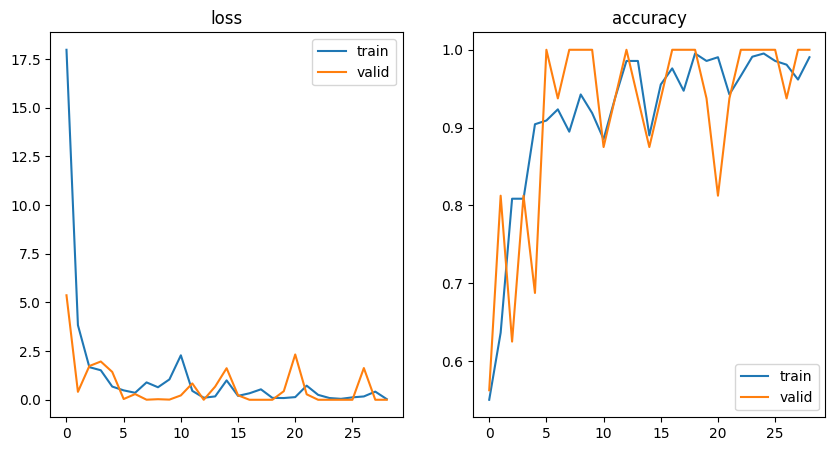

In [47]:
#logger.info(f'start traing')
# Early stoppingを適用してフィッティング
history = model.fit(train_generator,
                    validation_data = val_generator,
                    steps_per_epoch = train_generator.samples // BATCH_SIZE,
                    validation_steps = val_generator.samples // BATCH_SIZE,
                    verbose=True,
                    #callbacks=[tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1),
                    #           tensorflowkeras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)],
                    callbacks=[tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)],
                    epochs = epochs,
                    workers = 1
)

#logger.info(f'end traing')

# 評価する。
test_loss, test_acc = model.evaluate(val_generator)
#logger.result(f"test loss: {test_loss:.2f}, test accuracy: {test_acc:.2%}")

model_path = os.path.join(MODEL_DIR+'/cnn_'+architecture+'_OneHold.h5')
model.save(model_path)

plt.figure(figsize=(10, 5))  # グラフを表示するスペースを用意

for i in range(len(metrics)):
  metric = metrics[i]

  plt.subplot(1, 2, i+1)  # figureを1×2のスペースに分ける
  plt.title(metric)

  plt_train = history.history[metric]
  plt_valid  = history.history['val_' + metric]

  plt.plot(plt_train, label='train')
  plt.plot(plt_valid, label='valid')
  plt.legend()

analysis_path = os.path.join(ANALYSIS_DIR+"/metrics_one_hold.png")
plt.savefig(analysis_path)


#logger.info('end def fit_model_one_hold')

import shutil
import glob


#os.makedirs(TEST_DIR+'/dummy/', exist_ok=True)
#for image_path in glob.glob(TEST_DIR + '/*.jpeg'):
#    shutil.move(image_path, TEST_DIR + '/dummy')

#logger.info('start predict by one_hold')

ans = pd.read_csv(INPUT_DIR+"/sample_submission.csv",  header=None)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(ans, TEST_DIR, x_col=0, target_size=(IMG_WIDTH,IMG_HEIGHT),
                                                  batch_size=BATCH_SIZE, class_mode=None, shuffle=False)

prediction = model.predict(test_generator)
prediction = np.where(prediction < 0.5, 0, 1)

ans[1] = prediction

ans.to_csv(path_or_buf = SUBMISSION_DIR+"/submission_.csv", index=False, header=None)
#logger.info('start predict by one_hold')